In [1]:
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MAE
from sklearn.metrics import mean_absolute_error

def case_preprocessing():
    dataset = list()
    only_train_dataset = list()
    df = pd.DataFrame()
    train_df = pd.DataFrame()   # 새로운 Col 만들기 
    dir_path = 'C:\\Users\\gusrl\\opendrift\\drift_trajection'
    pastDir_path = 'C:\\Users\\gusrl\\opendrift\\drift_trajection\\Past_data'
    
    # hour, wind(바람의 x축,y축 방향 각각 제곱합의 루트), water(해류의 x축,y축 방향 각각 제곱합의 루트)
    for k in range(1,16):
        only_train_dataset.append(pd.read_csv(os.path.join(pastDir_path ,(str(k)+'.csv'))))
                                  
    # 2016 (case 7) (동해)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_003.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_005.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_010.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_011.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_015.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_016.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_040.csv')))

    # 2018(case 12) (서해)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_005.csv')))
    # dataset_list.append(pd.read_csv(os.path.join(dir_path,'2018_case_008.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_017.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_027.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_032.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_034.csv')))
    # dataset_list.append(pd.read_csv(os.path.join(dir_path,'2018_case_045.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_047.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_082.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_083.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_090.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_095.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_097.csv')))

    # 2019(case 4) (남해)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_000.csv')))
#     dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_001.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_006.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_007.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_005.csv')))
    
    # 과거데이터 전처리 
    for i in range(len(only_train_dataset)):
        # 동해 서해 남해 
        if i <8:
            only_train_dataset[i]['E'] = 0
            only_train_dataset[i]['W'] = 0
            only_train_dataset[i]['S'] = 1
        else:
            only_train_dataset[i]['E'] = 0
            only_train_dataset[i]['W'] = 1
            only_train_dataset[i]['S'] = 0
        
        # 시간처리를 위해 time의 object type -> datetime64로 변경
        only_train_dataset[i]['time'] = pd.to_datetime(only_train_dataset[i]['time'],format = '%Y-%m-%d %H:%M', errors = 'raise')
        # hour열 생성
        only_train_dataset[i]['hour'] = only_train_dataset[i]['time'].dt.hour
        # wind 열 생성
        only_train_dataset[i]['wind'] = (only_train_dataset[i]['wind_x']**2 + only_train_dataset[i]['wind_y']**2)**(1/2)
        # water열 생성
        only_train_dataset[i]['water'] = (only_train_dataset[i]['water_velocity_x']**2 + only_train_dataset[i]['water_velocity_y']**2)**(1/2)
        # diff_lon열 생성
        only_train_dataset[i]['diff_lon'] = only_train_dataset[i]['obs_x1_lon'].diff() 
        only_train_dataset[i]['diff_lon'][0] = 0
        # diff_lat열 생성
        only_train_dataset[i]['diff_lat'] = only_train_dataset[i]['obs_x1_lat'].diff()
        only_train_dataset[i]['diff_lat'][0] = 0
        # 'diff_wind_x'열 생성
        only_train_dataset[i]['diff_wind_x'] = only_train_dataset[i]['wind_x'].diff() 
        only_train_dataset[i]['diff_wind_x'][0] = 0
        # 'diff_wind_y'열 생성
        only_train_dataset[i]['diff_wind_y'] = only_train_dataset[i]['wind_y'].diff()
        only_train_dataset[i]['diff_wind_y'][0] = 0
        # 'diff_wind_x'열 생성
        only_train_dataset[i]['diff_water_velocity_x'] = only_train_dataset[i]['water_velocity_x'].diff() 
        only_train_dataset[i]['diff_water_velocity_x'][0] = 0
        # 'diff_wind_y'열 생성
        only_train_dataset[i]['diff_water_velocity_y'] = only_train_dataset[i]['water_velocity_y'].diff() 
        only_train_dataset[i]['diff_water_velocity_y'][0] = 0
        # 초기 이동 고려 (원-핫 인코딩)
        only_train_dataset[i]['initial'] = 0
        only_train_dataset[i]['not_initial'] = 0
        for j in range(0,10):
            only_train_dataset[i]['not_initial'][j] = 0
            only_train_dataset[i]['initial'][j] = 1
        
        # model_x2_lon
        # diff_lon열 생성
        only_train_dataset[i]['diff_mod_lon'] = only_train_dataset[i]['model_x2_lon'].diff() 
        only_train_dataset[i]['diff_mod_lon'][0] = 0
        # diff_lat열 생성
        only_train_dataset[i]['diff_mod_lat'] = only_train_dataset[i]['model_x2_lat'].diff()
        only_train_dataset[i]['diff_mod_lat'][0] = 0
        
        only_train_dataset[i]['water_velocity_x_10'] = only_train_dataset[i]['water_velocity_x'] * 10
        only_train_dataset[i]['water_velocity_y_10'] = only_train_dataset[i]['water_velocity_y'] * 10
        
        # diff열 생성
        only_train_dataset[i]['diff'] = (only_train_dataset[i]['diff_lon']**2 + only_train_dataset[i]['diff_lat']**2)**(1/2)
        
        # Null 값 제외
        
        only_train_dataset[i] = only_train_dataset[i].dropna()
        only_train_dataset[i] = only_train_dataset[i].reset_index(drop = True)
        
        
        # 초기좌표 (해역 나누기)
        only_train_dataset[i]['start_lon'] = only_train_dataset[i]['obs_x1_lon'][0]
        only_train_dataset[i]['start_lat'] = only_train_dataset[i]['obs_x1_lat'][0]
        
        # Smoothing (wind_x_ma, wind_y_ma, water_velocity_x_ma, water_velocity_y_ma 인자 추가) 
        only_train_dataset[i]['wind_x_ma'] = 0
        only_train_dataset[i]['wind_y_ma'] = 0
        only_train_dataset[i]['water_velocity_x_ma'] = 0
        only_train_dataset[i]['water_velocity_y_ma'] = 0 
        for j in range(1,len(only_train_dataset[i])-1):
            only_train_dataset[i]['wind_x_ma'][j] = (only_train_dataset[i]['wind_x'][j-1] + only_train_dataset[i]['wind_x'][j] + only_train_dataset[i]['wind_x'][j+1])/3
            only_train_dataset[i]['wind_y_ma'][j] = (only_train_dataset[i]['wind_y'][j-1] + only_train_dataset[i]['wind_y'][j] + only_train_dataset[i]['wind_y'][j+1])/3
            only_train_dataset[i]['water_velocity_x_ma'][j] = (only_train_dataset[i]['water_velocity_x'][j-1] + only_train_dataset[i]['water_velocity_x'][j] + only_train_dataset[i]['water_velocity_x'][j+1])/3
            only_train_dataset[i]['water_velocity_y_ma'][j] = (only_train_dataset[i]['water_velocity_y'][j-1] + only_train_dataset[i]['water_velocity_y'][j] + only_train_dataset[i]['water_velocity_y'][j+1])/3    
        df = only_train_dataset[i]
        indices = df.query('wind_x < -90 or wind_y < -90 or water_velocity_x < -90 or water_velocity_y < -90').index
        df.drop(indices, inplace=True)
        df.reset_index(drop = True, inplace=True)
        only_train_dataset[i] = df 
        
     # 기상청 데이터 전처리 
    for i in range(len(dataset)):
        # 동해 서해 남해 
        if i <7:
            dataset[i]['E'] = 1
            dataset[i]['W'] = 0
            dataset[i]['S'] = 0
        elif i >= 7 and i<18:
            dataset[i]['E'] = 0
            dataset[i]['W'] = 1
            dataset[i]['S'] = 0
        else:
            dataset[i]['E'] = 0
            dataset[i]['W'] = 0
            dataset[i]['S'] = 1
        
        # 시간처리를 위해 time의 object type -> datetime64로 변경
        dataset[i]['time'] = pd.to_datetime(dataset[i]['time'],format = '%Y-%m-%d %H:%M', errors = 'raise')
        # hour열 생성
        dataset[i]['hour'] = dataset[i]['time'].dt.hour
        # wind 열 생성
        dataset[i]['wind'] = (dataset[i]['wind_x']**2 + dataset[i]['wind_y']**2)**(1/2)
        # water열 생성
        dataset[i]['water'] = (dataset[i]['water_velocity_x']**2 + dataset[i]['water_velocity_y']**2)**(1/2)
        # diff_lon열 생성
        dataset[i]['diff_lon'] = dataset[i]['obs_x1_lon'].diff() 
        dataset[i]['diff_lon'][0] = 0
        # diff_lat열 생성
        dataset[i]['diff_lat'] = dataset[i]['obs_x1_lat'].diff()
        dataset[i]['diff_lat'][0] = 0
        # 'diff_wind_x'열 생성
        dataset[i]['diff_wind_x'] = dataset[i]['wind_x'].diff() 
        dataset[i]['diff_wind_x'][0] = 0
        # 'diff_wind_y'열 생성
        dataset[i]['diff_wind_y'] = dataset[i]['wind_y'].diff()
        dataset[i]['diff_wind_y'][0] = 0
        # 'diff_wind_x'열 생성
        dataset[i]['diff_water_velocity_x'] = dataset[i]['water_velocity_x'].diff() 
        dataset[i]['diff_water_velocity_x'][0] = 0
        # 'diff_wind_y'열 생성
        dataset[i]['diff_water_velocity_y'] = dataset[i]['water_velocity_y'].diff() 
        dataset[i]['diff_water_velocity_y'][0] = 0
        
        # 초기 이동 고려 (원-핫 인코딩)
        dataset[i]['initial'] = 0
        dataset[i]['not_initial'] = 1
        for j in range(0,30):
            dataset[i]['not_initial'][j] = 0
            dataset[i]['initial'][j] = 1
        
        # diff열 생성
        dataset[i]['diff'] = (dataset[i]['diff_lon']**2 + dataset[i]['diff_lat']**2)**(1/2)
        
        dataset[i]['diff_mod_lon'] = dataset[i]['model_x2_lon'].diff() 
        dataset[i]['diff_mod_lon'][0] = 0
        
        # diff_lat열 생성
        dataset[i]['diff_mod_lat'] = dataset[i]['model_x2_lat'].diff()
        dataset[i]['diff_mod_lat'][0] = 0
        
        # mod diff 
        dataset[i]['diff_mod'] = (dataset[i]['diff_mod_lon']**2 + dataset[i]['diff_mod_lat']**2)**(1/2)
        dataset[i]['diff_mod'] = dataset[i]['diff'].shift(1)
        
        # Null 값 제외
        dataset[i] = dataset[i].dropna()
        dataset[i] = dataset[i].reset_index(drop = True)
        
        # 초기좌표 (해역 나누기)
        dataset[i]['start_lon'] = dataset[i]['obs_x1_lon'][0]
        dataset[i]['start_lat'] = dataset[i]['obs_x1_lat'][0]
        
        # Smoothing (wind_x_ma, wind_y_ma, water_velocity_x_ma, water_velocity_y_ma 인자 추가) 
        dataset[i]['wind_x_ma'] = 0
        dataset[i]['wind_y_ma'] = 0
        dataset[i]['water_velocity_x_ma'] = 0
        dataset[i]['water_velocity_y_ma'] = 0 
        for j in range(1,len(dataset[i])-1):
            dataset[i]['wind_x_ma'][j] = (dataset[i]['wind_x'][j-1] + dataset[i]['wind_x'][j] + dataset[i]['wind_x'][j+1])/3
            dataset[i]['wind_y_ma'][j] = (dataset[i]['wind_y'][j-1] + dataset[i]['wind_y'][j] + dataset[i]['wind_y'][j+1])/3
            dataset[i]['water_velocity_x_ma'][j] = (dataset[i]['water_velocity_x'][j-1] + dataset[i]['water_velocity_x'][j] + dataset[i]['water_velocity_x'][j+1])/3
            dataset[i]['water_velocity_y_ma'][j] = (dataset[i]['water_velocity_y'][j-1] + dataset[i]['water_velocity_y'][j] + dataset[i]['water_velocity_y'][j+1])/3
        
        # 삭제 전 원본 df
        df = pd.concat([df,dataset[i]],ignore_index = True)
        # 불필요열 삭제 
        pre_df = dataset[i].drop(columns = ['time','obs_x1_lon','obs_x1_lat','model_x2_lon','model_x2_lat'])  
        train_df = pd.concat([train_df, pre_df[1:-1]],ignore_index = True)
        
    df = df.reset_index(drop = True)
    train_df = train_df.reset_index(drop = True)
    return dataset, df, train_df, only_train_dataset

def drift_mae(y, predict_y):
    mae = mean_absolute_error(y, predict_y)
    return mae


def n2_mae(y, predict_y):
    n = y.shape[0]
    error_sum = 0
    
    for i in range(n):
        error_sum += abs((y[i][0] - predict_y[i][0])) + abs(( y[i][1] - predict_y[i][1]))
    
    mae = error_sum/(2*n)   
    
    return mae


def paper_mae(y, predict_y): # 논문  
    n = y.shape[0]
    error_sum = 0
    
    for i in range(n):
        error_sum += abs(y[i][0] - predict_y[i][0]) + abs(y[i][1] - predict_y[i][1])
    
    mae = error_sum/n    
    return mae

def NCLS_score(y, predict_y): # 1시간 
        # dl_i 구하기 
        dl_list, dl_sum, o_sum = list(), list(), 0
        n = y.shape[0]
        for i in range(1, n):
            # 위도 1도는 111.321, 경도 1도는 87.74km, 단위 km
            d_lon = y[i][0] - y[i-1][0]  
            d_lat = y[i][1] - y[i-1][1]
            # 거리 구하기
            point_distance = np.sqrt(np.power(d_lon,2) + np.power(d_lat,2))
            dl_list.append(point_distance)
            
        for i in range(len(dl_list)):
            temp = 0
            for j in range(i+1):
                temp += dl_list[j]
            dl_sum.append(temp)

        for i in range(len(dl_sum)):
            o_sum += dl_sum[i]
        
        # 예측모델의 d_i 구하기
        d_list = list()
        for i in range(1,n):
            # 위도 1도는 111.321 # 경도 1도는 55.802km
            d_lon = y[i][0] - predict_y[i][0]  
            d_lat = y[i][1] - predict_y[i][1]
            # 거리 구하기
            point_distance = np.sqrt(np.power(d_lon,2) + np.power(d_lat,2))
            d_list.append(point_distance)

        # s 구하기
        d_sum, s, ss_score = 0, 0, 0

        for i in range(len(d_list)):
            d_sum += d_list[i]

        s = d_sum/o_sum
        
        if s > 1:
                ss_score = 0
        else:
            ss_score = 1-s
        
        return ss_score

def drift_trajection_show(index, y_pred): 
    %matplotlib inline

    # 실제 위치
    lon = dataset[index]['obs_x1_lon']
    lon = np.array(lon)
    lat = dataset[index]['obs_x1_lat']
    lat = np.array(lat)
    
    # baseline
    baseline_lon = dataset[index]['model_x2_lon']
    baseline_lon = np.array(baseline_lon)
    baseline_lat = dataset[index]['model_x2_lat']
    baseline_lat = np.array(baseline_lat)

    # 예측값 
    first_lon = lon[0]
    first_lat = lat[0]
    lon_pred = np.zeros((y_pred.shape[0]+1,))
    lat_pred = np.zeros((y_pred.shape[0]+1,))
    lon_pred[0] = first_lon 
    lat_pred[0] = first_lat
    
    for i in range(1, lon_pred.shape[0]):
        lon_pred[i] = lon_pred[i-1] + y_pred[i-1][0]
        lat_pred[i] = lat_pred[i-1] + y_pred[i-1][1]
        
    return lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred

def std_scaler(train_X, test_X):
    from sklearn.preprocessing import StandardScaler
    std = StandardScaler()
    std.fit(train_X)
    train_X_scaled = std.transform(train_X)
    test_X_scaled = std.transform(test_X)
    return train_X_scaled, test_X_scaled

def MinMax_scaler(train_X, test_X):
    from sklearn.preprocessing import MinMaxScaler
    mms = MinMaxScaler()
    mms.fit(train_X)
    train_X_scaled = mms.transform(train_X)
    test_X_scaled = mms.transform(test_X)
    return train_X_scaled, test_X_scaled
    
def roburst_scaler(train_X, test_X):
    from sklearn.preprocessing import RobustScaler
    rbs = RobustScaler()
    train_X_scaled = rbs.fit_transform(train_X)
    test_X_scaled = rbs.transform(test_X)
    return train_X_scaled, test_X_scaled


def maxAbsScaler(train_X, test_X):

    from sklearn.preprocessing import MaxAbsScaler
    maxAbsScaler = MaxAbsScaler()
    train_X_scaled = maxAbsScaler.fit_transform(train_X)
    test_X_scaled = maxAbsScaler.transform(test_X)
    return train_X_scaled, test_X_scaled

In [2]:
dataset, concat_df, train_df, only_train_dataset = case_preprocessing()

C:\Users\gusrl\AppData\Local\Temp\ipykernel_15624\1404270796.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_15624\1404270796.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_15624\1404270796.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_data

C:\Users\gusrl\AppData\Local\Temp\ipykernel_15624\1404270796.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_15624\1404270796.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_15624\1404270796.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_data

C:\Users\gusrl\AppData\Local\Temp\ipykernel_15624\1404270796.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['not_initial'][j] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_15624\1404270796.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['initial'][j] = 1
C:\Users\gusrl\AppData\Local\Temp\ipykernel_15624\1404270796.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train

C:\Users\gusrl\AppData\Local\Temp\ipykernel_15624\1404270796.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['wind_x_ma'][j] = (dataset[i]['wind_x'][j-1] + dataset[i]['wind_x'][j] + dataset[i]['wind_x'][j+1])/3
C:\Users\gusrl\AppData\Local\Temp\ipykernel_15624\1404270796.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['wind_y_ma'][j] = (dataset[i]['wind_y'][j-1] + dataset[i]['wind_y'][j] + dataset[i]['wind_y'][j+1])/3
C:\Users\gusrl\AppData\Local\Temp\ipykernel_15624\1404270796.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the c

C:\Users\gusrl\AppData\Local\Temp\ipykernel_15624\1404270796.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_mod_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_15624\1404270796.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_mod_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_15624\1404270796.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['wind_x_ma'][j]

C:\Users\gusrl\AppData\Local\Temp\ipykernel_15624\1404270796.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_mod_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_15624\1404270796.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_mod_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_15624\1404270796.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['wind_x_ma'][j]

C:\Users\gusrl\AppData\Local\Temp\ipykernel_15624\1404270796.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['wind_x_ma'][j] = (dataset[i]['wind_x'][j-1] + dataset[i]['wind_x'][j] + dataset[i]['wind_x'][j+1])/3
C:\Users\gusrl\AppData\Local\Temp\ipykernel_15624\1404270796.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['wind_y_ma'][j] = (dataset[i]['wind_y'][j-1] + dataset[i]['wind_y'][j] + dataset[i]['wind_y'][j+1])/3
C:\Users\gusrl\AppData\Local\Temp\ipykernel_15624\1404270796.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the c

C:\Users\gusrl\AppData\Local\Temp\ipykernel_15624\1404270796.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_mod_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_15624\1404270796.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_mod_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_15624\1404270796.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['wind_x_ma'][j]

--------------------- Model  0  ----------------------
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 30)                180       
                                                                 
 dense_133 (Dense)           (None, 1)                 31        
                                                                 
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
147/147 [==============================] - 1s 1ms/step - loss: 0.0352 - mae: 0.1301
Epoch 2/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0034 - mae: 0.0446
Epoch 3/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0013 - mae: 0.0285
Epoch 4/50
147/147 [==============================] - 0s 1ms/step - loss: 9.5826e-04 - mae: 0.0241
Epoch 5/50
1

147/147 [==============================] - 0s 1ms/step - loss: 2.3317e-04 - mae: 0.0117
Epoch 19/50
147/147 [==============================] - 0s 1ms/step - loss: 2.1280e-04 - mae: 0.0113
Epoch 20/50
147/147 [==============================] - 0s 1ms/step - loss: 1.8752e-04 - mae: 0.0106
Epoch 21/50
147/147 [==============================] - 0s 1ms/step - loss: 1.7004e-04 - mae: 0.0101
Epoch 22/50
147/147 [==============================] - 0s 1ms/step - loss: 1.5365e-04 - mae: 0.0096
Epoch 23/50
147/147 [==============================] - 0s 1ms/step - loss: 1.4217e-04 - mae: 0.0093
Epoch 24/50
147/147 [==============================] - 0s 999us/step - loss: 1.2948e-04 - mae: 0.0089
Epoch 25/50
147/147 [==============================] - 0s 1ms/step - loss: 1.1851e-04 - mae: 0.0085
Epoch 26/50
147/147 [==============================] - 0s 1ms/step - loss: 1.0974e-04 - mae: 0.0083
Epoch 27/50
147/147 [==============================] - 0s 992us/step - loss: 1.0101e-04 - mae: 0.0079
Epoch 28

147/147 [==============================] - 0s 1ms/step - loss: 7.4369e-05 - mae: 0.0064
Epoch 42/50
147/147 [==============================] - 0s 1ms/step - loss: 7.4683e-05 - mae: 0.0064
Epoch 43/50
147/147 [==============================] - 0s 1ms/step - loss: 7.3689e-05 - mae: 0.0064
Epoch 44/50
147/147 [==============================] - 0s 1ms/step - loss: 7.4675e-05 - mae: 0.0064
Epoch 45/50
147/147 [==============================] - 0s 1ms/step - loss: 7.5188e-05 - mae: 0.0063
Epoch 46/50
147/147 [==============================] - 0s 1ms/step - loss: 7.4615e-05 - mae: 0.0064
Epoch 47/50
147/147 [==============================] - 0s 1ms/step - loss: 6.9829e-05 - mae: 0.0061
Epoch 48/50
147/147 [==============================] - 0s 1ms/step - loss: 7.1977e-05 - mae: 0.0062
Epoch 49/50
147/147 [==============================] - 0s 1ms/step - loss: 7.5905e-05 - mae: 0.0064
Epoch 50/50
147/147 [==============================] - 0s 1ms/step - loss: 7.7232e-05 - mae: 0.0065
Model: "sequ

147/147 [==============================] - 0s 1ms/step - loss: 3.5304e-04 - mae: 0.0145
Epoch 8/50
147/147 [==============================] - 0s 1ms/step - loss: 3.0785e-04 - mae: 0.0135
Epoch 9/50
147/147 [==============================] - 0s 1ms/step - loss: 2.7728e-04 - mae: 0.0128
Epoch 10/50
147/147 [==============================] - 0s 1ms/step - loss: 2.4319e-04 - mae: 0.0120
Epoch 11/50
147/147 [==============================] - 0s 1ms/step - loss: 2.1455e-04 - mae: 0.0113
Epoch 12/50
147/147 [==============================] - 0s 1ms/step - loss: 1.9420e-04 - mae: 0.0107
Epoch 13/50
147/147 [==============================] - 0s 1ms/step - loss: 1.7610e-04 - mae: 0.0102
Epoch 14/50
147/147 [==============================] - 0s 1ms/step - loss: 1.6065e-04 - mae: 0.0098
Epoch 15/50
147/147 [==============================] - 0s 1ms/step - loss: 1.4543e-04 - mae: 0.0093
Epoch 16/50
147/147 [==============================] - 0s 1ms/step - loss: 1.3579e-04 - mae: 0.0089
Epoch 17/50
14

147/147 [==============================] - 0s 1ms/step - loss: 8.1949e-05 - mae: 0.0072
Epoch 33/50
147/147 [==============================] - 0s 1ms/step - loss: 7.4413e-05 - mae: 0.0068
Epoch 34/50
147/147 [==============================] - 0s 1ms/step - loss: 7.2244e-05 - mae: 0.0066
Epoch 35/50
147/147 [==============================] - 0s 1ms/step - loss: 6.6191e-05 - mae: 0.0064
Epoch 36/50
147/147 [==============================] - 0s 1ms/step - loss: 6.2379e-05 - mae: 0.0062
Epoch 37/50
147/147 [==============================] - 0s 1ms/step - loss: 6.4141e-05 - mae: 0.0062
Epoch 38/50
147/147 [==============================] - 0s 1ms/step - loss: 6.0372e-05 - mae: 0.0060
Epoch 39/50
147/147 [==============================] - 0s 1ms/step - loss: 5.8419e-05 - mae: 0.0059
Epoch 40/50
147/147 [==============================] - 0s 1ms/step - loss: 5.7833e-05 - mae: 0.0059
Epoch 41/50
147/147 [==============================] - 0s 1ms/step - loss: 5.3256e-05 - mae: 0.0057
Epoch 42/50


Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
147/147 [==============================] - 1s 1ms/step - loss: 0.0190 - mae: 0.0909
Epoch 2/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0013 - mae: 0.0277
Epoch 3/50
147/147 [==============================] - 0s 1ms/step - loss: 7.9693e-04 - mae: 0.0217
Epoch 4/50
147/147 [==============================] - 0s 1ms/step - loss: 6.6262e-04 - mae: 0.0198
Epoch 5/50
147/147 [==============================] - 0s 1ms/step - loss: 5.7591e-04 - mae: 0.0184
Epoch 6/50
147/147 [==============================] - 0s 1ms/step - loss: 5.1008e-04 - mae: 0.0173
Epoch 7/50
147/147 [==============================] - 0s 1ms/step - loss: 4.5844e-04 - mae: 0.0165
Epoch 8/50
147/147 [==============================] - 0s 1ms/step - loss: 4.0245e-04 - mae: 0.0153
Epoch 9/50
147/147 [==============================] - 0s 1ms/step - loss: 3.6044e-04 -

147/147 [==============================] - 0s 1ms/step - loss: 1.1445e-04 - mae: 0.0081
Epoch 23/50
147/147 [==============================] - 0s 1ms/step - loss: 1.1262e-04 - mae: 0.0079
Epoch 24/50
147/147 [==============================] - 0s 1ms/step - loss: 1.0656e-04 - mae: 0.0077
Epoch 25/50
147/147 [==============================] - 0s 1ms/step - loss: 1.0626e-04 - mae: 0.0077
Epoch 26/50
147/147 [==============================] - 0s 1ms/step - loss: 1.0201e-04 - mae: 0.0076
Epoch 27/50
147/147 [==============================] - 0s 1ms/step - loss: 1.0136e-04 - mae: 0.0075
Epoch 28/50
147/147 [==============================] - 0s 1ms/step - loss: 9.8164e-05 - mae: 0.0074
Epoch 29/50
147/147 [==============================] - 0s 1ms/step - loss: 9.7566e-05 - mae: 0.0075
Epoch 30/50
147/147 [==============================] - 0s 1ms/step - loss: 9.3571e-05 - mae: 0.0072
Epoch 31/50
147/147 [==============================] - 0s 1ms/step - loss: 8.9839e-05 - mae: 0.0071
Epoch 32/50


KeyboardInterrupt: 

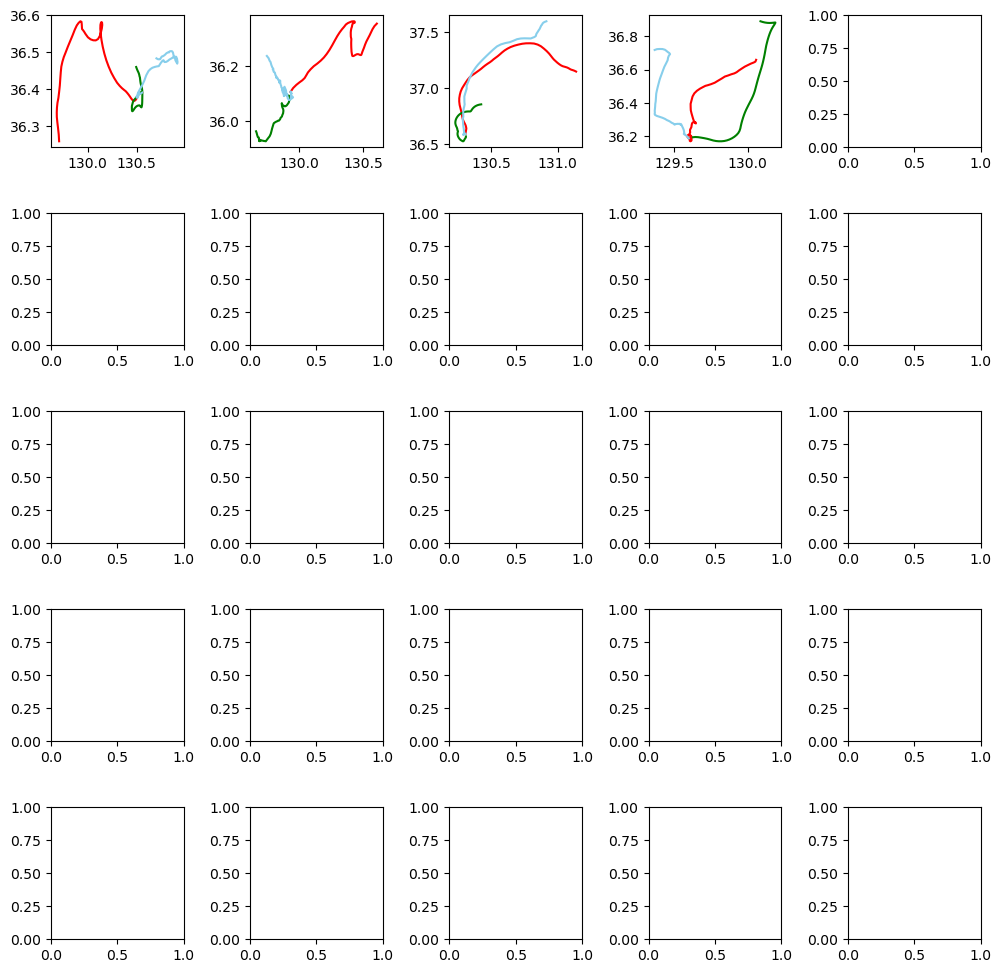

In [7]:
# MLP (activation relu) & roburst scaler & 특성 5
f, axes = plt.subplots(5, 5)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
baseline_MAE_list = list() 
baseline_NCLS_list = list()
MAE_list = list()
NCLS_list = list()

for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]
    
    train_X = train[0][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','diff']]
    train_y = train[0][['diff_lon', 'diff_lat']]
    
    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        trina_xi = train[j][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','diff']] 
        trina_yi = train[j][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # 과거 데이터 훈련데이터에 추가
    for k in range(len(only_train_dataset)):
        trina_xi = only_train_dataset[k][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','diff']] 
        trina_yi = only_train_dataset[k][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
      
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0) 
    
    # Test dataset
    test = dataset[i]
    test_X = test[['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','diff_mod']]
    test_X = test_X.rename(columns={'diff_mod':'diff'})
    test_X = test_X[1:]
    test_y = test[['diff_lon', 'diff_lat']]
    test_y = test_y[1:].to_numpy()
    
    
    train_X, test_X = roburst_scaler(train_X, test_X)    
    
    MLP_lon = tf.keras.Sequential([
    Dense(units = 30, input_dim = 5, activation = 'relu')
    ])
#     MLP_lon.add(Dense(units = 15, activation = 'relu'))
    MLP_lon.add(Dense(units = 1))
    MLP_lon.summary()
    MLP_lon.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    MLP_lon.fit(train_X, train_y[:,0], epochs = 50, batch_size = 20)
    
    MLP_lat = tf.keras.Sequential([
    Dense(units = 30, input_dim = 5, activation = 'relu')
    ])
#     MLP_lat.add(Dense(units = 15, activation = 'relu'))
    MLP_lat.add(Dense(units = 1))
    MLP_lat.summary()
    MLP_lat.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    MLP_lat.fit(train_X, train_y[:,1], epochs = 50, batch_size = 20)
    
    # model save
#     MLP.save(str(i)+'MLP_model.h5')

    # Predict
    y_pred_lon = MLP_lon.predict(test_X)
    y_pred_lat = MLP_lat.predict(test_X)
    y_pred = np.concatenate((y_pred_lon,y_pred_lat),axis = 1)
    
    # Plot
    lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred = drift_trajection_show(i,y_pred)
    row = i//5
    col = i%5
    axes[row][col].plot(lon, lat,'r-' ,baseline_lon, baseline_lat, 'g-', lon_pred, lat_pred, 'skyblue')   
    
    # evaluation 
    y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
    pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
      
    #mae
    # print(pred) nan 값
    print(drift_mae(y, pred))
    MAE_list.append(drift_mae(y, pred))
    
    #NCLS
    print(NCLS_score(y, pred))
    NCLS_list.append(NCLS_score(y, pred))

plt.show()

In [6]:
# stacking (meta RF depth=2) & 특징 5개 
mae_sum = 0
baseline_mae_sum = 0
NCLS_sum = 0
baseline_NCLS_sum = 0

for i in range(len(dataset)):
    mae_sum += MAE_list[i]
#     baseline_mae_sum += baseline_MAE_list[i]
    NCLS_sum += NCLS_list[i]
#     baseline_NCLS_sum += baseline_NCLS_list[i]

# 라이브러리 Mae    
print ('Model Mae : ', mae_sum/len(dataset) )
# print ('Baseline Mae : ', baseline_mae_sum/len(dataset) )
print ('Model NCLS : ', NCLS_sum/len(dataset) )
# print ('Baseline NCLS : ', baseline_NCLS_sum/len(dataset) )

Model Mae :  0.17611252289922447
Model NCLS :  0.5535947516487382


--------------------- Model  0  ----------------------
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_155 (Dense)           (None, 30)                300       
                                                                 
 dense_156 (Dense)           (None, 15)                465       
                                                                 
 dense_157 (Dense)           (None, 1)                 16        
                                                                 
Total params: 781
Trainable params: 781
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
147/147 [==============================] - 1s 1ms/step - loss: 0.0287 - mae: 0.1072
Epoch 2/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0037 - mae: 0.0439
Epoch 3/50
147/147 [==============================] - 0s 1ms/step - loss: 

147/147 [==============================] - 0s 1ms/step - loss: 3.0320e-04 - mae: 0.0130
Epoch 17/50
147/147 [==============================] - 0s 1ms/step - loss: 2.5975e-04 - mae: 0.0120
Epoch 18/50
147/147 [==============================] - 0s 1ms/step - loss: 2.3404e-04 - mae: 0.0115
Epoch 19/50
147/147 [==============================] - 0s 1ms/step - loss: 2.1731e-04 - mae: 0.0111
Epoch 20/50
147/147 [==============================] - 0s 1ms/step - loss: 2.0867e-04 - mae: 0.0109
Epoch 21/50
147/147 [==============================] - 0s 1ms/step - loss: 1.8952e-04 - mae: 0.0104
Epoch 22/50
147/147 [==============================] - 0s 1ms/step - loss: 1.8427e-04 - mae: 0.0101
Epoch 23/50
147/147 [==============================] - 0s 1ms/step - loss: 1.8003e-04 - mae: 0.0100
Epoch 24/50
147/147 [==============================] - 0s 1ms/step - loss: 1.6758e-04 - mae: 0.0097
Epoch 25/50
147/147 [==============================] - 0s 1ms/step - loss: 1.6558e-04 - mae: 0.0095
Epoch 26/50


147/147 [==============================] - 0s 1ms/step - loss: 9.3758e-05 - mae: 0.0075
Epoch 39/50
147/147 [==============================] - 0s 1ms/step - loss: 9.2453e-05 - mae: 0.0074
Epoch 40/50
147/147 [==============================] - 0s 1ms/step - loss: 8.4766e-05 - mae: 0.0070
Epoch 41/50
147/147 [==============================] - 0s 1ms/step - loss: 8.1003e-05 - mae: 0.0069
Epoch 42/50
147/147 [==============================] - 0s 1ms/step - loss: 7.9830e-05 - mae: 0.0068
Epoch 43/50
147/147 [==============================] - 0s 1ms/step - loss: 7.7565e-05 - mae: 0.0067
Epoch 44/50
147/147 [==============================] - 0s 1ms/step - loss: 8.3695e-05 - mae: 0.0070
Epoch 45/50
147/147 [==============================] - 0s 1ms/step - loss: 7.3563e-05 - mae: 0.0065
Epoch 46/50
147/147 [==============================] - 0s 1ms/step - loss: 7.3752e-05 - mae: 0.0065
Epoch 47/50
147/147 [==============================] - 0s 1ms/step - loss: 7.2575e-05 - mae: 0.0065
Epoch 48/50


147/147 [==============================] - 0s 1ms/step - loss: 0.0050 - mae: 0.0505
Epoch 3/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0027 - mae: 0.0383
Epoch 4/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0020 - mae: 0.0330
Epoch 5/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0015 - mae: 0.0294
Epoch 6/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0012 - mae: 0.0259
Epoch 7/50
147/147 [==============================] - 0s 1ms/step - loss: 9.4053e-04 - mae: 0.0231
Epoch 8/50
147/147 [==============================] - 0s 1ms/step - loss: 7.5694e-04 - mae: 0.0208
Epoch 9/50
147/147 [==============================] - 0s 1ms/step - loss: 6.5326e-04 - mae: 0.0193
Epoch 10/50
147/147 [==============================] - 0s 1ms/step - loss: 5.7199e-04 - mae: 0.0181
Epoch 11/50
147/147 [==============================] - 0s 1ms/step - loss: 4.9880e-04 - mae: 0.0169
Epoch 12/50
147/147 [==================

147/147 [==============================] - 0s 1ms/step - loss: 1.4421e-04 - mae: 0.0092
Epoch 27/50
147/147 [==============================] - 0s 1ms/step - loss: 1.6290e-04 - mae: 0.0095
Epoch 28/50
147/147 [==============================] - 0s 1ms/step - loss: 1.5033e-04 - mae: 0.0092
Epoch 29/50
147/147 [==============================] - 0s 1ms/step - loss: 1.2402e-04 - mae: 0.0085
Epoch 30/50
147/147 [==============================] - 0s 1ms/step - loss: 1.1403e-04 - mae: 0.0082
Epoch 31/50
147/147 [==============================] - 0s 1ms/step - loss: 1.0945e-04 - mae: 0.0080
Epoch 32/50
147/147 [==============================] - 0s 1ms/step - loss: 1.1281e-04 - mae: 0.0080
Epoch 33/50
147/147 [==============================] - 0s 1ms/step - loss: 1.1450e-04 - mae: 0.0081
Epoch 34/50
147/147 [==============================] - 0s 1ms/step - loss: 1.0300e-04 - mae: 0.0078
Epoch 35/50
147/147 [==============================] - 0s 1ms/step - loss: 1.3110e-04 - mae: 0.0084
Epoch 36/50


147/147 [==============================] - 0s 1ms/step - loss: 6.6385e-05 - mae: 0.0060
Epoch 49/50
147/147 [==============================] - 0s 1ms/step - loss: 6.8535e-05 - mae: 0.0061
Epoch 50/50
147/147 [==============================] - 0s 1ms/step - loss: 6.4750e-05 - mae: 0.0059
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_176 (Dense)           (None, 30)                300       
                                                                 
 dense_177 (Dense)           (None, 15)                465       
                                                                 
 dense_178 (Dense)           (None, 1)                 16        
                                                                 
Total params: 781
Trainable params: 781
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
147/147 [===========

147/147 [==============================] - 0s 1ms/step - loss: 6.3724e-04 - mae: 0.0191
Epoch 13/50
147/147 [==============================] - 0s 1ms/step - loss: 5.7857e-04 - mae: 0.0183
Epoch 14/50
147/147 [==============================] - 0s 1ms/step - loss: 5.2091e-04 - mae: 0.0173
Epoch 15/50
147/147 [==============================] - 0s 1ms/step - loss: 4.8188e-04 - mae: 0.0167
Epoch 16/50
147/147 [==============================] - 0s 1ms/step - loss: 4.2005e-04 - mae: 0.0155
Epoch 17/50
147/147 [==============================] - 0s 1ms/step - loss: 3.8287e-04 - mae: 0.0149
Epoch 18/50
147/147 [==============================] - 0s 1ms/step - loss: 3.5005e-04 - mae: 0.0141
Epoch 19/50
147/147 [==============================] - 0s 1ms/step - loss: 3.1618e-04 - mae: 0.0135
Epoch 20/50
147/147 [==============================] - 0s 1ms/step - loss: 2.9234e-04 - mae: 0.0130
Epoch 21/50
147/147 [==============================] - 0s 1ms/step - loss: 2.6789e-04 - mae: 0.0124
Epoch 22/50


147/147 [==============================] - 0s 1ms/step - loss: 4.7004e-05 - mae: 0.0052
Epoch 37/50
147/147 [==============================] - 0s 1ms/step - loss: 4.6857e-05 - mae: 0.0052
Epoch 38/50
147/147 [==============================] - 0s 1ms/step - loss: 4.6036e-05 - mae: 0.0051
Epoch 39/50
147/147 [==============================] - 0s 1ms/step - loss: 4.7729e-05 - mae: 0.0052
Epoch 40/50
147/147 [==============================] - 0s 1ms/step - loss: 4.6984e-05 - mae: 0.0052
Epoch 41/50
147/147 [==============================] - 0s 1ms/step - loss: 4.6598e-05 - mae: 0.0051
Epoch 42/50
147/147 [==============================] - 0s 1ms/step - loss: 4.7260e-05 - mae: 0.0052
Epoch 43/50
147/147 [==============================] - 0s 1ms/step - loss: 4.6046e-05 - mae: 0.0051
Epoch 44/50
147/147 [==============================] - 0s 1ms/step - loss: 4.8459e-05 - mae: 0.0051
Epoch 45/50
147/147 [==============================] - 0s 1ms/step - loss: 4.4803e-05 - mae: 0.0051
Epoch 46/50


_________________________________________________________________
Epoch 1/50
147/147 [==============================] - 1s 1ms/step - loss: 0.0411 - mae: 0.1142
Epoch 2/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0040 - mae: 0.0457
Epoch 3/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0022 - mae: 0.0347
Epoch 4/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0016 - mae: 0.0293
Epoch 5/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0013 - mae: 0.0261
Epoch 6/50
147/147 [==============================] - 0s 1ms/step - loss: 9.9239e-04 - mae: 0.0233
Epoch 7/50
147/147 [==============================] - 0s 1ms/step - loss: 8.4846e-04 - mae: 0.0218
Epoch 8/50
147/147 [==============================] - 0s 1ms/step - loss: 7.1782e-04 - mae: 0.0201
Epoch 9/50
147/147 [==============================] - 0s 1ms/step - loss: 6.3188e-04 - mae: 0.0189
Epoch 10/50
147/147 [==============================] - 0s 1ms/s

147/147 [==============================] - 0s 1ms/step - loss: 1.4702e-04 - mae: 0.0093
Epoch 23/50
147/147 [==============================] - 0s 1ms/step - loss: 1.4012e-04 - mae: 0.0090
Epoch 24/50
147/147 [==============================] - 0s 2ms/step - loss: 1.3663e-04 - mae: 0.0088
Epoch 25/50
147/147 [==============================] - 0s 2ms/step - loss: 1.3988e-04 - mae: 0.0087
Epoch 26/50
147/147 [==============================] - 0s 1ms/step - loss: 1.2006e-04 - mae: 0.0083
Epoch 27/50
147/147 [==============================] - 0s 2ms/step - loss: 1.1977e-04 - mae: 0.0082
Epoch 28/50
147/147 [==============================] - 0s 2ms/step - loss: 1.2737e-04 - mae: 0.0082
Epoch 29/50
147/147 [==============================] - 0s 1ms/step - loss: 1.1910e-04 - mae: 0.0080
Epoch 30/50
147/147 [==============================] - 0s 1ms/step - loss: 1.0779e-04 - mae: 0.0078
Epoch 31/50
147/147 [==============================] - 0s 1ms/step - loss: 1.8813e-04 - mae: 0.0084
Epoch 32/50


147/147 [==============================] - 0s 1ms/step - loss: 5.6964e-05 - mae: 0.0057
Epoch 47/50
147/147 [==============================] - 0s 1ms/step - loss: 4.8503e-05 - mae: 0.0053
Epoch 48/50
147/147 [==============================] - 0s 1ms/step - loss: 6.8864e-05 - mae: 0.0060
Epoch 49/50
147/147 [==============================] - 0s 1ms/step - loss: 5.1805e-05 - mae: 0.0054
Epoch 50/50
3/3 [==============================] - 0s 2ms/step
0.40398775607937565
0.235088246206412
--------------------- Model  7  ----------------------
Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_197 (Dense)           (None, 30)                300       
                                                                 
 dense_198 (Dense)           (None, 15)                465       
                                                                 
 dense_199 (Dense)           (None, 1

147/147 [==============================] - 0s 1ms/step - loss: 3.6899e-04 - mae: 0.0133
Epoch 11/50
147/147 [==============================] - 0s 1ms/step - loss: 3.1335e-04 - mae: 0.0123
Epoch 12/50
147/147 [==============================] - 0s 1ms/step - loss: 2.8043e-04 - mae: 0.0117
Epoch 13/50
147/147 [==============================] - 0s 1ms/step - loss: 2.4247e-04 - mae: 0.0110
Epoch 14/50
147/147 [==============================] - 0s 1ms/step - loss: 2.1075e-04 - mae: 0.0104
Epoch 15/50
147/147 [==============================] - 0s 1ms/step - loss: 1.9349e-04 - mae: 0.0100
Epoch 16/50
147/147 [==============================] - 0s 1ms/step - loss: 1.7325e-04 - mae: 0.0096
Epoch 17/50
147/147 [==============================] - 0s 1ms/step - loss: 1.5930e-04 - mae: 0.0092
Epoch 18/50
147/147 [==============================] - 0s 1ms/step - loss: 1.4644e-04 - mae: 0.0090
Epoch 19/50
147/147 [==============================] - 0s 1ms/step - loss: 1.3740e-04 - mae: 0.0087
Epoch 20/50


147/147 [==============================] - 0s 1ms/step - loss: 7.4086e-05 - mae: 0.0065
Epoch 33/50
147/147 [==============================] - 0s 1ms/step - loss: 7.4199e-05 - mae: 0.0065
Epoch 34/50
147/147 [==============================] - 0s 1ms/step - loss: 7.3566e-05 - mae: 0.0064
Epoch 35/50
147/147 [==============================] - 0s 1ms/step - loss: 7.6060e-05 - mae: 0.0064
Epoch 36/50
147/147 [==============================] - 0s 1ms/step - loss: 6.9969e-05 - mae: 0.0062
Epoch 37/50
147/147 [==============================] - 0s 1ms/step - loss: 6.9559e-05 - mae: 0.0062
Epoch 38/50
147/147 [==============================] - 0s 1ms/step - loss: 7.1633e-05 - mae: 0.0062
Epoch 39/50
147/147 [==============================] - 0s 1ms/step - loss: 6.6629e-05 - mae: 0.0061
Epoch 40/50
147/147 [==============================] - 0s 1ms/step - loss: 6.7996e-05 - mae: 0.0061
Epoch 41/50
147/147 [==============================] - 0s 1ms/step - loss: 7.3335e-05 - mae: 0.0063
Epoch 42/50


 dense_210 (Dense)           (None, 15)                465       
                                                                 
 dense_211 (Dense)           (None, 1)                 16        
                                                                 
Total params: 781
Trainable params: 781
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
147/147 [==============================] - 1s 1ms/step - loss: 0.0131 - mae: 0.0807
Epoch 2/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0033 - mae: 0.0431
Epoch 3/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0017 - mae: 0.0312
Epoch 4/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0012 - mae: 0.0265
Epoch 5/50
147/147 [==============================] - 0s 1ms/step - loss: 9.0513e-04 - mae: 0.0228
Epoch 6/50
147/147 [==============================] - 0s 1ms/step - loss: 7.0410e-04 - mae: 0.0201
Epoch 7/50
147/147 [========

147/147 [==============================] - 0s 1ms/step - loss: 6.7709e-05 - mae: 0.0062
Epoch 21/50
147/147 [==============================] - 0s 1ms/step - loss: 6.6786e-05 - mae: 0.0062
Epoch 22/50
147/147 [==============================] - 0s 1ms/step - loss: 6.3510e-05 - mae: 0.0061
Epoch 23/50
147/147 [==============================] - 0s 1ms/step - loss: 6.2306e-05 - mae: 0.0060
Epoch 24/50
147/147 [==============================] - 0s 1ms/step - loss: 5.8476e-05 - mae: 0.0058
Epoch 25/50
147/147 [==============================] - 0s 1ms/step - loss: 6.0138e-05 - mae: 0.0058
Epoch 26/50
147/147 [==============================] - 0s 1ms/step - loss: 5.7768e-05 - mae: 0.0058
Epoch 27/50
147/147 [==============================] - 0s 1ms/step - loss: 5.3964e-05 - mae: 0.0056
Epoch 28/50
147/147 [==============================] - 0s 1ms/step - loss: 5.3670e-05 - mae: 0.0055
Epoch 29/50
147/147 [==============================] - 0s 1ms/step - loss: 5.4835e-05 - mae: 0.0056
Epoch 30/50


147/147 [==============================] - 0s 1ms/step - loss: 8.4740e-05 - mae: 0.0069
Epoch 43/50
147/147 [==============================] - 0s 1ms/step - loss: 7.8728e-05 - mae: 0.0066
Epoch 44/50
147/147 [==============================] - 0s 1ms/step - loss: 8.0369e-05 - mae: 0.0067
Epoch 45/50
147/147 [==============================] - 0s 1ms/step - loss: 8.5378e-05 - mae: 0.0069
Epoch 46/50
147/147 [==============================] - 0s 1ms/step - loss: 7.6312e-05 - mae: 0.0065
Epoch 47/50
147/147 [==============================] - 0s 1ms/step - loss: 7.7612e-05 - mae: 0.0066
Epoch 48/50
147/147 [==============================] - 0s 1ms/step - loss: 6.9829e-05 - mae: 0.0063
Epoch 49/50
147/147 [==============================] - 0s 1ms/step - loss: 7.7911e-05 - mae: 0.0066
Epoch 50/50
147/147 [==============================] - 0s 1ms/step - loss: 7.1234e-05 - mae: 0.0063
Model: "sequential_76"
_________________________________________________________________
 Layer (type)          

147/147 [==============================] - 0s 1ms/step - loss: 5.2337e-04 - mae: 0.0158
Epoch 7/50
147/147 [==============================] - 0s 1ms/step - loss: 3.6873e-04 - mae: 0.0134
Epoch 8/50
147/147 [==============================] - 0s 1ms/step - loss: 3.1839e-04 - mae: 0.0123
Epoch 9/50
147/147 [==============================] - 0s 1ms/step - loss: 2.8102e-04 - mae: 0.0113
Epoch 10/50
147/147 [==============================] - 0s 1ms/step - loss: 2.4332e-04 - mae: 0.0107
Epoch 11/50
147/147 [==============================] - 0s 1ms/step - loss: 2.2354e-04 - mae: 0.0102
Epoch 12/50
147/147 [==============================] - 0s 1ms/step - loss: 2.0788e-04 - mae: 0.0097
Epoch 13/50
147/147 [==============================] - 0s 1ms/step - loss: 1.8300e-04 - mae: 0.0092
Epoch 14/50
147/147 [==============================] - 0s 1ms/step - loss: 1.6442e-04 - mae: 0.0087
Epoch 15/50
147/147 [==============================] - 0s 1ms/step - loss: 1.5021e-04 - mae: 0.0083
Epoch 16/50
147

147/147 [==============================] - 0s 1ms/step - loss: 1.1481e-04 - mae: 0.0081
Epoch 31/50
147/147 [==============================] - 0s 1ms/step - loss: 1.2174e-04 - mae: 0.0083
Epoch 32/50
147/147 [==============================] - 0s 1ms/step - loss: 1.1053e-04 - mae: 0.0079
Epoch 33/50
147/147 [==============================] - 0s 1ms/step - loss: 1.1081e-04 - mae: 0.0079
Epoch 34/50
147/147 [==============================] - 0s 1ms/step - loss: 1.0262e-04 - mae: 0.0077
Epoch 35/50
147/147 [==============================] - 0s 1ms/step - loss: 9.5771e-05 - mae: 0.0075
Epoch 36/50
147/147 [==============================] - 0s 1ms/step - loss: 9.4453e-05 - mae: 0.0074
Epoch 37/50
147/147 [==============================] - 0s 1ms/step - loss: 9.4498e-05 - mae: 0.0074
Epoch 38/50
147/147 [==============================] - 0s 1ms/step - loss: 9.3093e-05 - mae: 0.0073
Epoch 39/50
147/147 [==============================] - 0s 1ms/step - loss: 9.1027e-05 - mae: 0.0073
Epoch 40/50


 dense_230 (Dense)           (None, 30)                300       
                                                                 
 dense_231 (Dense)           (None, 15)                465       
                                                                 
 dense_232 (Dense)           (None, 1)                 16        
                                                                 
Total params: 781
Trainable params: 781
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
147/147 [==============================] - 1s 1ms/step - loss: 0.0235 - mae: 0.1027
Epoch 2/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0047 - mae: 0.0509
Epoch 3/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0023 - mae: 0.0353
Epoch 4/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0014 - mae: 0.0278
Epoch 5/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0010 - mae: 0.0234

147/147 [==============================] - 0s 1ms/step - loss: 1.1773e-04 - mae: 0.0080
Epoch 17/50
147/147 [==============================] - 0s 1ms/step - loss: 1.0794e-04 - mae: 0.0078
Epoch 18/50
147/147 [==============================] - 0s 1ms/step - loss: 1.0677e-04 - mae: 0.0077
Epoch 19/50
147/147 [==============================] - 0s 1ms/step - loss: 1.0127e-04 - mae: 0.0075
Epoch 20/50
147/147 [==============================] - 0s 1ms/step - loss: 9.6977e-05 - mae: 0.0074
Epoch 21/50
147/147 [==============================] - 0s 1ms/step - loss: 9.4835e-05 - mae: 0.0073
Epoch 22/50
147/147 [==============================] - 0s 1ms/step - loss: 9.0332e-05 - mae: 0.0070
Epoch 23/50
147/147 [==============================] - 0s 1ms/step - loss: 8.6362e-05 - mae: 0.0069
Epoch 24/50
147/147 [==============================] - 0s 1ms/step - loss: 8.2401e-05 - mae: 0.0068
Epoch 25/50
147/147 [==============================] - 0s 1ms/step - loss: 8.0308e-05 - mae: 0.0066
Epoch 26/50


147/147 [==============================] - 0s 1ms/step - loss: 5.3010e-05 - mae: 0.0056
Epoch 41/50
147/147 [==============================] - 0s 1ms/step - loss: 5.1195e-05 - mae: 0.0054
Epoch 42/50
147/147 [==============================] - 0s 1ms/step - loss: 5.1449e-05 - mae: 0.0055
Epoch 43/50
147/147 [==============================] - 0s 1ms/step - loss: 5.5212e-05 - mae: 0.0057
Epoch 44/50
147/147 [==============================] - 0s 1ms/step - loss: 4.9718e-05 - mae: 0.0054
Epoch 45/50
147/147 [==============================] - 0s 1ms/step - loss: 5.3385e-05 - mae: 0.0055
Epoch 46/50
147/147 [==============================] - 0s 1ms/step - loss: 4.9361e-05 - mae: 0.0054
Epoch 47/50
147/147 [==============================] - 0s 1ms/step - loss: 4.6335e-05 - mae: 0.0052
Epoch 48/50
147/147 [==============================] - 0s 1ms/step - loss: 4.7788e-05 - mae: 0.0052
Epoch 49/50
147/147 [==============================] - 0s 1ms/step - loss: 4.9877e-05 - mae: 0.0053
Epoch 50/50


147/147 [==============================] - 0s 1ms/step - loss: 0.0012 - mae: 0.0262
Epoch 5/50
147/147 [==============================] - 0s 1ms/step - loss: 8.8756e-04 - mae: 0.0230
Epoch 6/50
147/147 [==============================] - 0s 1ms/step - loss: 7.3495e-04 - mae: 0.0208
Epoch 7/50
147/147 [==============================] - 0s 1ms/step - loss: 6.0481e-04 - mae: 0.0190
Epoch 8/50
147/147 [==============================] - 0s 1ms/step - loss: 4.9819e-04 - mae: 0.0172
Epoch 9/50
147/147 [==============================] - 0s 1ms/step - loss: 4.4440e-04 - mae: 0.0162
Epoch 10/50
147/147 [==============================] - 0s 1ms/step - loss: 3.7419e-04 - mae: 0.0150
Epoch 11/50
147/147 [==============================] - 0s 1ms/step - loss: 3.3250e-04 - mae: 0.0141
Epoch 12/50
147/147 [==============================] - 0s 1ms/step - loss: 3.0272e-04 - mae: 0.0134
Epoch 13/50
147/147 [==============================] - 0s 1ms/step - loss: 2.5720e-04 - mae: 0.0124
Epoch 14/50
147/147 [

147/147 [==============================] - 0s 1ms/step - loss: 1.4078e-04 - mae: 0.0089
Epoch 27/50
147/147 [==============================] - 0s 1ms/step - loss: 1.1379e-04 - mae: 0.0082
Epoch 28/50
147/147 [==============================] - 0s 1ms/step - loss: 1.1024e-04 - mae: 0.0080
Epoch 29/50
147/147 [==============================] - 0s 1ms/step - loss: 1.3133e-04 - mae: 0.0086
Epoch 30/50
147/147 [==============================] - 0s 1ms/step - loss: 1.0649e-04 - mae: 0.0080
Epoch 31/50
147/147 [==============================] - 0s 1ms/step - loss: 1.1294e-04 - mae: 0.0080
Epoch 32/50
147/147 [==============================] - 0s 1ms/step - loss: 1.5245e-04 - mae: 0.0091
Epoch 33/50
147/147 [==============================] - 0s 1ms/step - loss: 1.1022e-04 - mae: 0.0078
Epoch 34/50
147/147 [==============================] - 0s 1ms/step - loss: 1.0590e-04 - mae: 0.0077
Epoch 35/50
147/147 [==============================] - 0s 1ms/step - loss: 1.0726e-04 - mae: 0.0078
Epoch 36/50


3/3 [==============================] - 0s 2ms/step
0.03934975612025777
0.8402566143959156
--------------------- Model  16  ----------------------
Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_251 (Dense)           (None, 30)                300       
                                                                 
 dense_252 (Dense)           (None, 15)                465       
                                                                 
 dense_253 (Dense)           (None, 1)                 16        
                                                                 
Total params: 781
Trainable params: 781
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
147/147 [==============================] - 1s 1ms/step - loss: 0.0198 - mae: 0.0940
Epoch 2/50
147/147 [==============================] - 0s 1ms/step - loss: 0.00

147/147 [==============================] - 0s 1ms/step - loss: 2.1275e-04 - mae: 0.0111
Epoch 15/50
147/147 [==============================] - 0s 1ms/step - loss: 1.9698e-04 - mae: 0.0106
Epoch 16/50
147/147 [==============================] - 0s 1ms/step - loss: 1.6524e-04 - mae: 0.0099
Epoch 17/50
147/147 [==============================] - 0s 1ms/step - loss: 1.6542e-04 - mae: 0.0098
Epoch 18/50
147/147 [==============================] - 0s 1ms/step - loss: 1.5384e-04 - mae: 0.0095
Epoch 19/50
147/147 [==============================] - 0s 1ms/step - loss: 1.3710e-04 - mae: 0.0090
Epoch 20/50
147/147 [==============================] - 0s 1ms/step - loss: 1.2034e-04 - mae: 0.0084
Epoch 21/50
147/147 [==============================] - 0s 1ms/step - loss: 1.1679e-04 - mae: 0.0084
Epoch 22/50
147/147 [==============================] - 0s 1ms/step - loss: 1.1589e-04 - mae: 0.0083
Epoch 23/50
147/147 [==============================] - 0s 1ms/step - loss: 1.0459e-04 - mae: 0.0079
Epoch 24/50


147/147 [==============================] - 0s 1ms/step - loss: 7.4057e-05 - mae: 0.0064
Epoch 37/50
147/147 [==============================] - 0s 1ms/step - loss: 6.8895e-05 - mae: 0.0062
Epoch 38/50
147/147 [==============================] - 0s 1ms/step - loss: 6.9011e-05 - mae: 0.0062
Epoch 39/50
147/147 [==============================] - 0s 1ms/step - loss: 6.9807e-05 - mae: 0.0062
Epoch 40/50
147/147 [==============================] - 0s 1ms/step - loss: 6.8484e-05 - mae: 0.0061
Epoch 41/50
147/147 [==============================] - 0s 1ms/step - loss: 9.1675e-05 - mae: 0.0066
Epoch 42/50
147/147 [==============================] - 0s 1ms/step - loss: 6.7947e-05 - mae: 0.0061
Epoch 43/50
147/147 [==============================] - 0s 1ms/step - loss: 7.8243e-05 - mae: 0.0062
Epoch 44/50
147/147 [==============================] - 0s 1ms/step - loss: 6.7789e-05 - mae: 0.0061
Epoch 45/50
147/147 [==============================] - 0s 1ms/step - loss: 6.4963e-05 - mae: 0.0059
Epoch 46/50


Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
147/147 [==============================] - 1s 1ms/step - loss: 0.0316 - mae: 0.1148
Epoch 2/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0036 - mae: 0.0442
Epoch 3/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0020 - mae: 0.0329
Epoch 4/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0013 - mae: 0.0267
Epoch 5/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0010 - mae: 0.0235
Epoch 6/50
147/147 [==============================] - 0s 1ms/step - loss: 8.1431e-04 - mae: 0.0211
Epoch 7/50
147/147 [==============================] - 0s 1ms/step - loss: 6.7997e-04 - mae: 0.0193
Epoch 8/50
147/147 [==============================] - 0s 1ms/step - loss: 5.7741e-04 - mae: 0.0177
Epoch 9/50
147/147 [==============================] - 0s 1ms/step - loss: 5.0274e-04 - mae: 0.0166
Epoch 10/50
147/147 [==================

147/147 [==============================] - 0s 2ms/step - loss: 1.7597e-04 - mae: 0.0101
Epoch 25/50
147/147 [==============================] - 0s 2ms/step - loss: 1.5657e-04 - mae: 0.0096
Epoch 26/50
147/147 [==============================] - 0s 1ms/step - loss: 2.1289e-04 - mae: 0.0107
Epoch 27/50
147/147 [==============================] - 0s 2ms/step - loss: 1.4047e-04 - mae: 0.0091
Epoch 28/50
147/147 [==============================] - 0s 1ms/step - loss: 1.3377e-04 - mae: 0.0089
Epoch 29/50
147/147 [==============================] - 0s 1ms/step - loss: 1.2420e-04 - mae: 0.0086
Epoch 30/50
147/147 [==============================] - 0s 1ms/step - loss: 1.1693e-04 - mae: 0.0082
Epoch 31/50
147/147 [==============================] - 0s 1ms/step - loss: 1.1725e-04 - mae: 0.0082
Epoch 32/50
147/147 [==============================] - 0s 1ms/step - loss: 1.0676e-04 - mae: 0.0079
Epoch 33/50
147/147 [==============================] - 0s 1ms/step - loss: 1.0722e-04 - mae: 0.0079
Epoch 34/50


147/147 [==============================] - 0s 1ms/step - loss: 7.0848e-05 - mae: 0.0062
Epoch 47/50
147/147 [==============================] - 0s 1ms/step - loss: 7.6915e-05 - mae: 0.0064
Epoch 48/50
147/147 [==============================] - 0s 1ms/step - loss: 7.4967e-05 - mae: 0.0063
Epoch 49/50
147/147 [==============================] - 0s 1ms/step - loss: 6.8855e-05 - mae: 0.0061
Epoch 50/50
147/147 [==============================] - 0s 1ms/step - loss: 6.7118e-05 - mae: 0.0060
Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_272 (Dense)           (None, 30)                300       
                                                                 
 dense_273 (Dense)           (None, 15)                465       
                                                                 
 dense_274 (Dense)           (None, 1)                 16        
                           

143/143 [==============================] - 0s 1ms/step - loss: 8.5257e-04 - mae: 0.0221
Epoch 11/50
143/143 [==============================] - 0s 1ms/step - loss: 7.5811e-04 - mae: 0.0207
Epoch 12/50
143/143 [==============================] - 0s 1ms/step - loss: 6.6927e-04 - mae: 0.0196
Epoch 13/50
143/143 [==============================] - 0s 1ms/step - loss: 5.9168e-04 - mae: 0.0184
Epoch 14/50
143/143 [==============================] - 0s 1ms/step - loss: 5.3625e-04 - mae: 0.0175
Epoch 15/50
143/143 [==============================] - 0s 1ms/step - loss: 4.8454e-04 - mae: 0.0166
Epoch 16/50
143/143 [==============================] - 0s 1ms/step - loss: 4.4154e-04 - mae: 0.0160
Epoch 17/50
143/143 [==============================] - 0s 1ms/step - loss: 4.0098e-04 - mae: 0.0151
Epoch 18/50
143/143 [==============================] - 0s 1ms/step - loss: 3.7050e-04 - mae: 0.0147
Epoch 19/50
143/143 [==============================] - 0s 1ms/step - loss: 3.5123e-04 - mae: 0.0142
Epoch 20/50


143/143 [==============================] - 0s 1ms/step - loss: 7.1845e-05 - mae: 0.0065
Epoch 35/50
143/143 [==============================] - 0s 1ms/step - loss: 6.9059e-05 - mae: 0.0065
Epoch 36/50
143/143 [==============================] - 0s 1ms/step - loss: 6.6053e-05 - mae: 0.0063
Epoch 37/50
143/143 [==============================] - 0s 1ms/step - loss: 6.3277e-05 - mae: 0.0061
Epoch 38/50
143/143 [==============================] - 0s 1ms/step - loss: 6.5285e-05 - mae: 0.0063
Epoch 39/50
143/143 [==============================] - 0s 1ms/step - loss: 6.2318e-05 - mae: 0.0061
Epoch 40/50
143/143 [==============================] - 0s 1ms/step - loss: 6.4429e-05 - mae: 0.0061
Epoch 41/50
143/143 [==============================] - 0s 1ms/step - loss: 6.1356e-05 - mae: 0.0060
Epoch 42/50
143/143 [==============================] - 0s 1ms/step - loss: 6.7154e-05 - mae: 0.0062
Epoch 43/50
143/143 [==============================] - 0s 1ms/step - loss: 5.8822e-05 - mae: 0.0058
Epoch 44/50


                                                                 
Total params: 781
Trainable params: 781
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
147/147 [==============================] - 1s 1ms/step - loss: 0.0178 - mae: 0.0836
Epoch 2/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0033 - mae: 0.0424
Epoch 3/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0020 - mae: 0.0333
Epoch 4/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0015 - mae: 0.0285
Epoch 5/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0011 - mae: 0.0252
Epoch 6/50
147/147 [==============================] - 0s 1ms/step - loss: 8.6839e-04 - mae: 0.0224
Epoch 7/50
147/147 [==============================] - 0s 1ms/step - loss: 7.2580e-04 - mae: 0.0205
Epoch 8/50
147/147 [==============================] - 0s 1ms/step - loss: 6.0507e-04 - mae: 0.0186
Epoch 9/50
147/147 [============

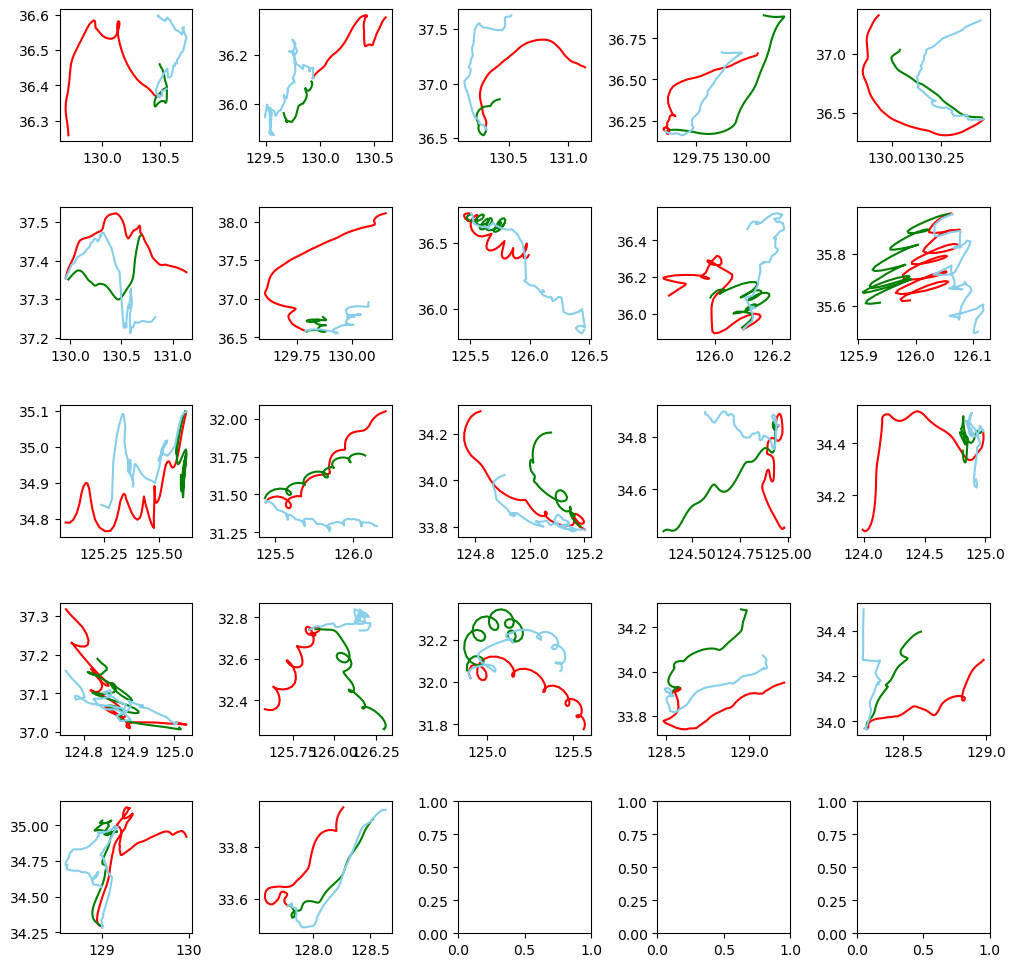

In [13]:
# MLP (activation relu) & roburst scaler & 특성 5
f, axes = plt.subplots(5, 5)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
baseline_MAE_list = list() 
baseline_NCLS_list = list()
MAE_list = list()
NCLS_list = list()

for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]
    
    train_X = train[0][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','diff_wind_x','diff_wind_y','water_velocity_x','water_velocity_y','diff']]
    train_y = train[0][['diff_lon', 'diff_lat']]
    
    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        trina_xi = train[j][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','diff_wind_x','diff_wind_y','water_velocity_x','water_velocity_y','diff']] 
        trina_yi = train[j][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # 과거 데이터 훈련데이터에 추가
    for k in range(len(only_train_dataset)):
        trina_xi = only_train_dataset[k][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','diff_wind_x','diff_wind_y','water_velocity_x','water_velocity_y','diff']] 
        trina_yi = only_train_dataset[k][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
      
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0) 
    
    # Test dataset
    test = dataset[i]
    test_X = test[['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x','diff_wind_x','diff_wind_y','water_velocity_x','water_velocity_y','diff_mod']]
    test_X = test_X.rename(columns={'diff_mod':'diff'})
    test_X = test_X[1:]
    test_y = test[['diff_lon', 'diff_lat']]
    test_y = test_y[1:].to_numpy()
    
    
    train_X, test_X = roburst_scaler(train_X, test_X)    
    
    MLP_lon = tf.keras.Sequential([
    Dense(units = 30, input_dim = 9, activation = 'relu')
    ])
    MLP_lon.add(Dense(units = 15, activation = 'relu'))
    MLP_lon.add(Dense(units = 1))
    MLP_lon.summary()
    MLP_lon.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    MLP_lon.fit(train_X, train_y[:,0], epochs = 50, batch_size = 20)
    
    MLP_lat = tf.keras.Sequential([
    Dense(units = 30, input_dim = 9, activation = 'relu')
    ])
    MLP_lat.add(Dense(units = 15, activation = 'relu'))
    MLP_lat.add(Dense(units = 1))
    MLP_lat.summary()
    MLP_lat.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    MLP_lat.fit(train_X, train_y[:,1], epochs = 50, batch_size = 20)
    
    # model save
#     MLP.save(str(i)+'MLP_model.h5')

    # Predict
    y_pred_lon = MLP_lon.predict(test_X)
    y_pred_lat = MLP_lat.predict(test_X)
    y_pred = np.concatenate((y_pred_lon,y_pred_lat),axis = 1)
    
    # Plot
    lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred = drift_trajection_show(i,y_pred)
    row = i//5
    col = i%5
    axes[row][col].plot(lon, lat,'r-' ,baseline_lon, baseline_lat, 'g-', lon_pred, lat_pred, 'skyblue')   
    
    # evaluation 
    y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
    pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
      
    #mae
    # print(pred) nan 값
    print(drift_mae(y, pred))
    MAE_list.append(drift_mae(y, pred))
    
    #NCLS
    print(NCLS_score(y, pred))
    NCLS_list.append(NCLS_score(y, pred))

plt.show()

In [14]:
# stacking (meta RF depth=2) & 특징 5개 
mae_sum = 0
baseline_mae_sum = 0
NCLS_sum = 0
baseline_NCLS_sum = 0

for i in range(len(dataset)):
    mae_sum += MAE_list[i]
#     baseline_mae_sum += baseline_MAE_list[i]
    NCLS_sum += NCLS_list[i]
#     baseline_NCLS_sum += baseline_NCLS_list[i]

# 라이브러리 Mae    
print ('Model Mae : ', mae_sum/len(dataset) )
# print ('Baseline Mae : ', baseline_mae_sum/len(dataset) )
print ('Model NCLS : ', NCLS_sum/len(dataset) )
# print ('Baseline NCLS : ', baseline_NCLS_sum/len(dataset) )

Model Mae :  0.18708973059393957
Model NCLS :  0.525904192474766
